# The Dice Problem

Suppose I have a box of dice that contains a 4-sided die, a 6-sided die, an 8-sided die, a 12-sided die, and a 20-sided die. 

Suppose I select a die from the box at random, roll it, and get a 6. What is the probability that I rolled each die?

In [38]:
%matplotlib inline
from ThinkBayes.code.thinkbayes import Pmf
from ThinkBayes.code.thinkbayes import Suite
from __future__ import division
import matplotlib.pyplot as plt 

In [2]:
class Dice(Suite):
    def Likelihood(self, data, hypo):
        if hypo<data:
            return 0
        else:
            return 1/hypo

In [3]:
suite = Dice([4, 6, 8, 12, 20])

In [4]:
suite.Update(6)

0.08500000000000002

In [7]:
# Posterior Distribution
suite.Print()

4 0.0
6 0.392156862745
8 0.294117647059
12 0.196078431373
20 0.117647058824


In [8]:
# What if we roll a few more times and get 6, 8, 7, 7, 5, and 4?
for roll in [6, 8, 7, 7, 5, 4]:
    suite.Update(roll)
suite.Print()

4 0.0
6 0.0
8 0.943248453672
12 0.0552061280613
20 0.0015454182665


# The Locomotive Problem

“A railroad numbers its locomotives in order 1..N. One day you see a locomotive with the number 60. Estimate how many loco- motives the railroad has.”

Let's assume that N is equally likely to be any value from 1 to 1000.

In [9]:
hypos = xrange(1, 1001)

Now, all we need is a likelihood function.

In [10]:
class Train(Suite):
    def Likelihood(self, data, hypo):
        if hypo<data:
            return 0
        else:
            return 1/hypo

In [11]:
suite = Train(hypos)

In [12]:
suite.Update(60)

0.0028222671142652746

In [24]:
x,y = zip(*suite.Items())

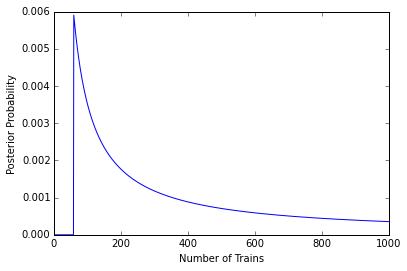

In [29]:
plt.plot(x,y)
plt.xlabel("Number of Trains")
plt.ylabel("Posterior Probability")

The most likely value, if you had to guess, is 60. That might not seem like a very good guess; after all, what are the chances that you just happened to see the train with the highest number? Nevertheless, if you want to maxi- mize the chance of getting the answer exactly right, you should guess 60.
But maybe that’s not the right goal. An alternative is to compute the mean of the posterior distribution:

In [31]:
# MMSE
# https://en.wikipedia.org/wiki/Minimum_mean_square_error
suite.Mean()

333.41989326371095

# What about the prior?

Recall that with a uniform prior from 1 to 1000, the mean of the posterior is 333. With an upper bound of 500, we get a posterior mean of 207, and with an upper bound of 2000, the posterior mean is 552.
So that’s bad. There are two ways to proceed:
* Get more data
* Get more background information

With more data, posterior distributions based on different priors tend to converge. For example, suppose that in addition to train 60 we also see trains 30 and 90. 

In [33]:
hypos = xrange(1, 501)
suite = Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

151.84958795903822

In [34]:
hypos = xrange(1, 1001)
suite = Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

164.3055864227336

In [35]:
hypos = xrange(1, 2001)
suite = Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

171.3381810915094

So the differences are smaller.

# An alternative prior

It is probably not reasonable to as- sume that a train-operating company with 1000 locomotives is just as likely as a company with only 1.

Mathematically, a power law means that the number of companies with a given size is inversely proportional to size, or
$$ PMF(x) = \frac{1}{x^{\alpha}} $$

We can construct a power-law prior like this:

In [56]:
class Train(Dice):
    def __init__(self, hypos, alpha=1.0):
        Pmf.__init__(self)
        for hypo in hypos:
            self.Set(hypo, hypo**(-alpha))
        self.Normalize()

In [44]:
hypos = xrange(1, 1001)
suite= Train(hypos)
suite.Update(60)

0.002111667688705239

Again, the upper bound is arbitrary, but with a power law prior, the poste- rior is less sensitive to this choice.

In [45]:
suite.Mean()

178.54735317971574

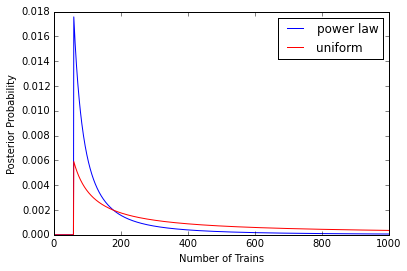

In [53]:
xpower,ypower = zip(*suite.Items())
axpower = plt.plot(xpower,ypower, label="power law")
axuniform = plt.plot(x,y, label="uniform", color='r')
plt.legend()
plt.xlabel("Number of Trains")
plt.ylabel("Posterior Probability")

In [59]:
hypos = xrange(1, 501)
suite= Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

130.70846986256004

In [60]:
hypos = xrange(1, 1001)
suite= Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

133.2752313750312

In [61]:
hypos = xrange(1, 2001)
suite= Train(hypos)
for data in [60, 30, 90]:
    suite.Update(data)
suite.Mean()

133.99746308073065

Now the differences are much smaller. In fact, with an arbitrarily large up- per bound, the mean converges on 134.
So the power law prior is more realistic, because it is based on general in- formation about the size of companies, and it behaves better in practice.


# Credible Intervals

Once you have computed a posterior distribution, it is often useful to sum- marize the results with a single point estimate or an interval. For point es- timates it is common to use the mean, median, or the value with maximum likelihood.

For intervals we usually report two values computed so that there is a 90% chance that the unknown value falls between them (or any other probabil- ity). These values define a credible interval.

A function that computes percentiles:

In [62]:
def Percentile(pmf, percentage):
    p = percentage/100.0
    total = 0
    for val, prob in pmf.Items():
        total += prob
        if total > p:
            return val    

In [63]:
interval = Percentile(suite, 5), Percentile(suite, 95)

In [64]:
print interval

(91, 243)


# Cumulative Distribution

In [65]:
cdf = suite.MakeCdf()

In [67]:
interval = cdf.Percentile(5), cdf.Percentile(95)